<center><h1 style="font-size:3em"> Few-shot text classification </h1></center>
<br>
<center><i style="font-size:1.3em">With pre-trained word embeddings and a human in the loop</i></center>

This notebook contains:
- Implementation of Few-Shot Text Classification with Pre-Trained Word Embeddings and a Human in the Loop by Katherine Bailey and Sunny Chopra Acquia: https://arxiv.org/pdf/1804.02063.pdf
- A comprehensive guide to the paper can be found here : https://katbailey.github.io/talks/Few-shot%20text%20classification.pdf
- Includes Easy Data Augmentation (EDA) package : https://github.com/jasonwei20/eda_nlp/blob/master/code/eda.py introduced after this paper : https://arxiv.org/pdf/1901.11196.pdf

**Use case** : A user has a column of short texts (e.g user reviews) but those comments are not labeled. We ask the user to hand-label just a few texts for each class (i.e. few-shot), and provide a method that leverages pre-trained embeddings to generalize the classification.

In [41]:
import pandas as pd
import numpy as np
from random import seed
from random import sample
import random
from random import shuffle
import re

seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import gensim.downloader as api
from gensim.models.keyedvectors import Word2VecKeyedVectors

from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy import spatial

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet 

In [42]:
stop_words = ['i', 'me', 'my', 'myself', 'we', 'our', 
'ours', 'ourselves', 'you', 'your', 'yours', 
'yourself', 'yourselves', 'he', 'him', 'his', 
'himself', 'she', 'her', 'hers', 'herself', 
'it', 'its', 'itself', 'they', 'them', 'their', 
'theirs', 'themselves', 'what', 'which', 'who', 
'whom', 'this', 'that', 'these', 'those', 'am', 
'is', 'are', 'was', 'were', 'be', 'been', 'being', 
'have', 'has', 'had', 'having', 'do', 'does', 'did',
'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or',
'because', 'as', 'until', 'while', 'of', 'at', 
'by', 'for', 'with', 'about', 'against', 'between',
'into', 'through', 'during', 'before', 'after', 
'above', 'below', 'to', 'from', 'up', 'down', 'in',
'out', 'on', 'off', 'over', 'under', 'again', 
'further', 'then', 'once', 'here', 'there', 'when', 
'where', 'why', 'how', 'all', 'any', 'both', 'each', 
'few', 'more', 'most', 'other', 'some', 'such', 'no', 
'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 
'very', 's', 't', 'can', 'will', 'just', 'don', 
'should', 'now', '']

In [43]:
#model2 = api.load('glove-twitter-25')
model2 = api.load('word2vec-google-news-300')

# I. Load the data

The dataset comes from Stackoverflow Short Text Classification : https://github.com/jacoxu/StackOverflow

We will split the dataset into a training set (anywhere between 1 to 50 training examples per class), and a test set (much larger).

In [44]:
df = pd.read_csv("stack.csv")

Let's first clean the text and keep only characters :

In [45]:
def get_only_chars(line):

    clean_line = ""

    line = line.replace("’", "")
    line = line.replace("'", "")
    line = line.replace("-", " ") #replace hyphens with spaces
    line = line.replace("\t", " ")
    line = line.replace("\n", " ")
    line = line.lower()

    for char in line:
        if char in 'qwertyuiopasdfghjklzxcvbnm ':
            clean_line += char
        else:
            clean_line += ' '

    clean_line = re.sub(' +',' ',clean_line) #delete extra spaces
    if clean_line[0] == ' ':
        clean_line = clean_line[1:]
    return clean_line

In [46]:
df['Text'] = df['Text'].apply(lambda x: get_only_chars(x))

In [47]:
df.head()

,Text,Label
0,how do i fill a dataset or a datatable from a ...,18
1,how do you page a collection with linq,18
2,best subversion clients for windows vista bit,3
3,best practice collaborative environment bin di...,3
4,visual studio setup project per user registry ...,7


# II. Prepare the data

Let's first clean the text and keep only characters :

In [48]:
num_classes = 2
sample_size = 4

Generate samples that contains K samples of each class :

In [49]:
def gen_sample(sample_size, num_classes):
    
    df_1 = df[(df["Label"]<num_classes + 1)].reset_index().drop(["index"], axis=1).reset_index().drop(["index"], axis=1)
    train = df_1[df_1["Label"] == np.unique(df_1['Label'])[0]].sample(sample_size)
    
    train_index = train.index.tolist()
    
    for i in range(1,num_classes):
        train_2 = df_1[df_1["Label"] == np.unique(df_1['Label'])[i]].sample(sample_size)
        train = pd.concat([train, train_2], axis=0)
        train_index.extend(train_2.index.tolist())
        
    test = df_1[~df_1.index.isin(train_index)]

    return train, test

In [51]:
train, test = gen_sample(sample_size, num_classes)

In [52]:
train

,Text,Label
1521,how to get wordpress page id after looping posts,1
1737,using wp query to pull content from a specific...,1
1740,wordpress how to show just posts on main index,1
1660,wordpress is it possible to make one particula...,1
103,unit testing for pl sql,2
777,oracle form builder switching between tabs in ...,2
111,how to find oracle error codes that could resu...,2
627,oracle merge partition from procedure giving e...,2


In [53]:
train.shape

(8, 2)

Text processing to split, find token id and return embedidng:

In [50]:
def transform_sentence(text, model):
    
    """
    Mean embedding vector
    """
    
    def preprocess_text(raw_text, model=model):
        
        """ 
        Eexcluding unknown words and get corresponding token
        """
        
        raw_text = raw_text.split()
        
        return list(filter(lambda x: x in model.vocab, raw_text))
    
    tokens = preprocess_text(text)
    
    if not tokens:
        return np.zeros(model.vector_size)

    text_vector = np.mean(model[tokens], axis=0)
    
    return np.array(text_vector)

## II.1. Classify Text with Cosine Similarity

We will now use cosine similarity between the embeddings of the text to classify and the average embeddings of all classes. A new example therefore belongs to the class it is the closest to.

<img src='Images/nlp_fs_4.png' width="50%" >

In [55]:
def classify_txt(txt, mean_embedding):
    
    best_dist = 1
    best_label = -1
    
    for cl in range(num_classes):
        
        dist = spatial.distance.cosine(transform_sentence(txt, model2), mean_embedding[cl])
        
        if dist < best_dist :
            best_dist = dist
            best_label = cl+1
        
    return best_label

This function returns the accuracy on the test set given a number of classes and a number of samples per class:

In [56]:
# Process text and predict on the test set

def return_score(sample_size, num_classes):
    
    train, test = gen_sample(sample_size, num_classes)
    
    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    mean_embedding = {}
    for cl in range(num_classes):
        mean_embedding[cl] = np.mean((X_train_mean[y_train == cl + 1]), axis=0)
        
    y_pred = [classify_txt(t, mean_embedding) for t in test['Text'].values]
    
    return accuracy_score(y_pred, y_test)

This function run the `return_score` function on all sample sizes and all number of classes in the specified range:

In [ ]:
all_accuracy = {2:[],3:[],4:[],5:[]}

for num_samples in range(1,50):
    for num_cl in range(2, 6):
        all_accuracy[num_cl].append(return_score(num_samples,num_cl))

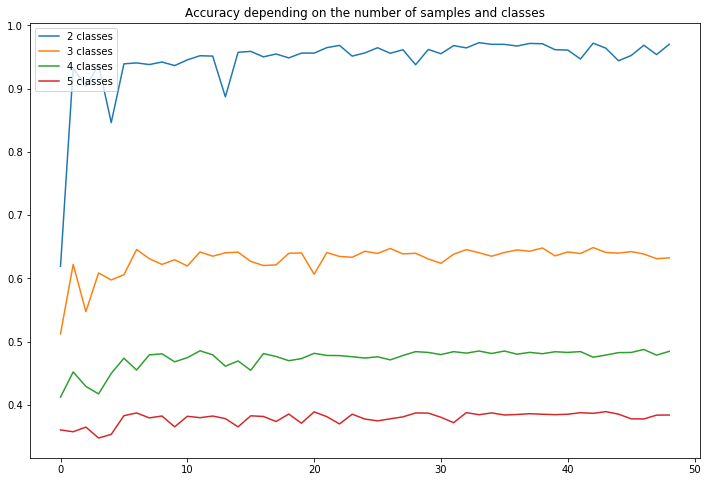

In [410]:
# Display accuracy
plt.figure(figsize=(12,8))
plt.plot(all_accuracy[2], label="2 classes")
plt.plot(all_accuracy[3], label="3 classes")
plt.plot(all_accuracy[4], label="4 classes")
plt.plot(all_accuracy[5], label="5 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

## II.2. Classify Text with K-NN

The approach of distance metric is quite restrictive since it relies on comparing the embedding of a sentence (which is itself an average of word embeddings), with the average of the embedding of all training examples within a class. Proposed extension with K-Nearest Neighbors Classifier.

<img src='Images/nlp_fs_6.png' width="30%" >

In [57]:
def return_score_knn(sample_size, num_classes):
    
    train, test = gen_sample(sample_size, num_classes)
    
    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)
        
    clf = KNeighborsClassifier(n_neighbors=sample_size, p=2)
    clf.fit(X_train_mean, y_train)
    
    y_pred = clf.predict(X_test_mean)
    
    return accuracy_score(y_pred, y_test)


In [ ]:
all_accuracy_knn = {2:[],3:[],4:[],5:[]}

for num_samples in range(1,50):
    for num_cl in range(2, 6):
        all_accuracy_knn[num_cl].append(return_score_knn(num_samples,num_cl))

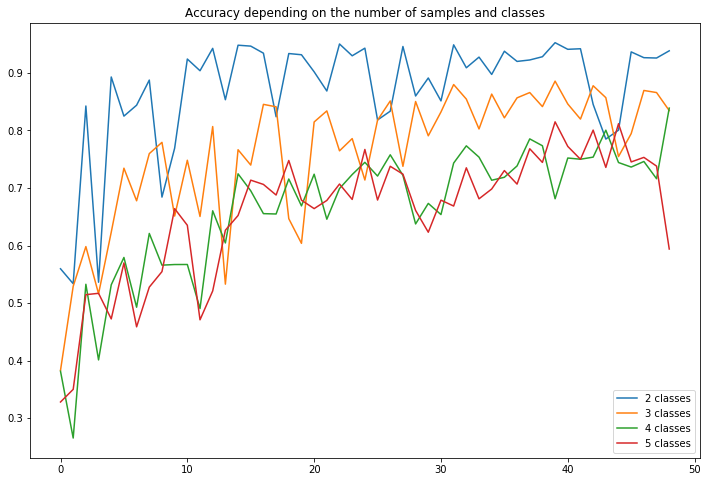

In [413]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_knn[2], label="2 classes")
plt.plot(all_accuracy_knn[3], label="3 classes")
plt.plot(all_accuracy_knn[4], label="4 classes")
plt.plot(all_accuracy_knn[5], label="5 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

When we have really few training samples (less than 10), the cosine-based approach seems to outperform the K-NN. However, once we consider more than 10-12 training samples, the accuracy with 4 classes improves from 40% to 67% !

## II.3. Summary

In [414]:
df_results = pd.DataFrame({
    'Nb Classes':[2,3,4,5], 
    'min K-NN':[min(all_accuracy_knn[2]), 
                min(all_accuracy_knn[3]), 
                min(all_accuracy_knn[4]), 
                min(all_accuracy_knn[5])],
    'min Cosine':[min(all_accuracy[2]), 
            min(all_accuracy[3]), 
            min(all_accuracy[4]), 
            min(all_accuracy[5])],
    'mean K-NN':[np.mean(all_accuracy_knn[2]), 
                np.mean(all_accuracy_knn[3]), 
                np.mean(all_accuracy_knn[4]), 
                np.mean(all_accuracy_knn[5])],
    'mean Cosine':[np.mean(all_accuracy[2]), 
            np.mean(all_accuracy[3]), 
            np.mean(all_accuracy[4]), 
            np.mean(all_accuracy[5])],
    'max K-NN':[max(all_accuracy_knn[2]), 
                max(all_accuracy_knn[3]), 
                max(all_accuracy_knn[4]), 
                max(all_accuracy_knn[5])],
    'max Cosine':[max(all_accuracy[2]), 
            max(all_accuracy[3]), 
            max(all_accuracy[4]), 
            max(all_accuracy[5])]
})

In [415]:
df_results

,Nb Classes,min K-NN,min Cosine,mean K-NN,mean Cosine,max K-NN,max Cosine
0,2,0.533567,0.619119,0.871367,0.944429,0.952604,0.972567
1,3,0.383050,0.512179,0.763637,0.629524,0.885764,0.648555
2,4,0.265281,0.412162,0.665189,0.473001,0.838854,0.487408
3,5,0.327928,0.347390,0.658054,0.378756,0.815000,0.389121


# III. Data Augmentation

When it comes to few-shot learning, the main issue is the number of training samples. In this section, we explore data augmentation techniques for few shot learning.

## III.1. Replace words

This functions replaces a random word in a sentence by one of its synonyms based on WordNet synonyms dictionnary.

In [58]:
def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word): 
        for l in syn.lemmas(): 
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

def iterative_replace(df):
    
    df = df.reset_index().drop(['index'], axis=1)
    index_row = df.index
    df_2 = pd.DataFrame()
    
    for row in index_row:
        for k in range(1,6):
            df_2 = df_2.append({'Text':synonym_replacement(df.loc[row]['Text'], k), 'Label':df.loc[row]['Label']}, ignore_index=True)
    return df_2

## III.2. Delete words

This functions deletes a random word in a sentence.

In [59]:
def random_deletion(words, p):

    words = words.split()
    
    #obviously, if there's only one word, don't delete it
    if len(words) == 1:
        return words

    #randomly delete words with probability p
    new_words = []
    for word in words:
        r = random.uniform(0, 1)
        if r > p:
            new_words.append(word)

    #if you end up deleting all words, just return a random word
    if len(new_words) == 0:
        rand_int = random.randint(0, len(words)-1)
        return [words[rand_int]]

    sentence = ' '.join(new_words)
    
    return sentence

def iterative_delete(df):
    
    df = df.reset_index().drop(['index'], axis=1)
    index_row = df.index
    df_2 = pd.DataFrame()
    
    for row in index_row:
        df_2 = df_2.append({'Text':random_deletion(df.loc[row]['Text'], 0.25), 'Label':df.loc[row]['Label']}, ignore_index=True)
    return df_2

## III.3. Random Swap

This functions swaps 2 random words in a sentence.

In [67]:
def random_swap(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        new_words = swap_word(new_words)
        
    sentence = ' '.join(new_words)
    
    return sentence

def swap_word(new_words):
    
    random_idx_1 = random.randint(0, len(new_words)-1)
    random_idx_2 = random_idx_1
    counter = 0
    
    while random_idx_2 == random_idx_1:
        random_idx_2 = random.randint(0, len(new_words)-1)
        counter += 1
        
        if counter > 3:
            return new_words
    
    new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1] 
    return new_words

def iterative_swap(df):
    
    df = df.reset_index().drop(['index'], axis=1)
    index_row = df.index
    df_2 = pd.DataFrame()
    for row in index_row:
        df_2 = df_2.append({'Text':random_swap(df.loc[row]['Text'], 2), 'Label':df.loc[row]['Label']}, ignore_index=True)
    return df_2

## III.4. Random Insertion

This functions randomly inserts a synonym of a word in a sentence.

In [61]:
def random_insertion(words, n):
    
    words = words.split()
    new_words = words.copy()
    
    for _ in range(n):
        add_word(new_words)
        
    sentence = ' '.join(new_words)
    return sentence

def add_word(new_words):
    
    synonyms = []
    counter = 0
    
    while len(synonyms) < 1:
        random_word = new_words[random.randint(0, len(new_words)-1)]
        synonyms = get_synonyms(random_word)
        counter += 1
        if counter >= 10:
            return
        
    random_synonym = synonyms[0]
    random_idx = random.randint(0, len(new_words)-1)
    new_words.insert(random_idx, random_synonym)
    
def iterative_insert(df):
    
    df = df.reset_index().drop(['index'], axis=1)
    index_row = df.index
    df_2 = pd.DataFrame()
    
    for row in index_row:
        df_2 = df_2.append({'Text':random_insertion(df.loc[row]['Text'], 2), 'Label':df.loc[row]['Label']}, ignore_index=True)
        
    return df_2

## III.5. Data Augmentation

Apply the data augmentation:

In [62]:
df_replace = iterative_replace(train)
df_delete = iterative_delete(train)
df_swap = iterative_swap(train)
df_insert = iterative_insert(train)

train = pd.concat([train, df_replace, df_delete, df_swap, df_insert], axis=0).reset_index().drop(['index'], axis=1)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [63]:
train.shape

(72, 2)

In [64]:
X_train = train['Text']
y_train = train['Label'].values
X_test = test['Text']
y_test = test['Label'].values

X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

### III.5.a. Cosine

Apply the cosine distance for the classification:

In [ ]:
all_accuracy_aug = {2:[],3:[],4:[],5:[]}

for num_samples in range(1,50):
    for num_cl in range(2, 6):
        all_accuracy_aug[num_cl].append(return_score(num_samples,num_cl))

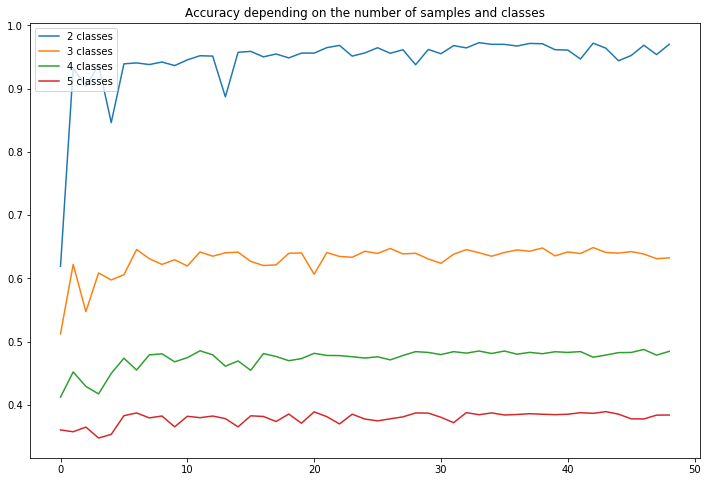

In [31]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_aug[2], label="2 classes")
plt.plot(all_accuracy_aug[3], label="3 classes")
plt.plot(all_accuracy_aug[4], label="4 classes")
plt.plot(all_accuracy_aug[5], label="5 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

### III.5.b. K-NN

Apply the K-NN classifier:

In [32]:
all_accuracy_knn_aug = {2:[],3:[],4:[],5:[]}
for num_samples in range(1,50):
    for num_cl in range(2, 6):
        all_accuracy_knn_aug[num_cl].append(return_score_knn(num_samples,num_cl))

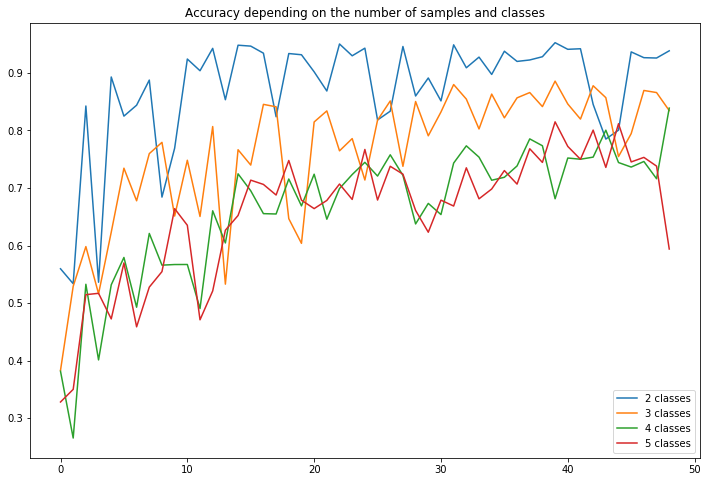

In [33]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_knn_aug[2], label="2 classes")
plt.plot(all_accuracy_knn_aug[3], label="3 classes")
plt.plot(all_accuracy_knn_aug[4], label="4 classes")
plt.plot(all_accuracy_knn_aug[5], label="5 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

### III.5.c. Random Forest

Improved classifier with a random forest:

In [65]:
def return_score_rf(sample_size, num_classes):
    
    train, test = gen_sample(sample_size, num_classes)
    
    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)
        
    clf = RandomForestClassifier(n_estimators=150)
    clf.fit(X_train_mean, y_train)
    
    y_pred = clf.predict(X_test_mean)
    return accuracy_score(y_pred, y_test)

In [37]:
all_accuracy_rf_aug = {2:[],3:[],4:[],5:[]}
for num_samples in range(1,50):
    for num_cl in range(2, 6):
        all_accuracy_rf_aug[num_cl].append(return_score_rf(num_samples,num_cl))

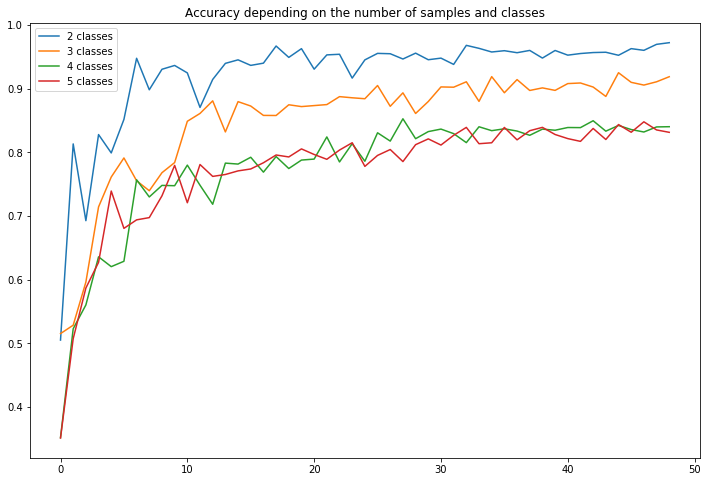

In [38]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_rf_aug[2], label="2 classes")
plt.plot(all_accuracy_rf_aug[3], label="3 classes")
plt.plot(all_accuracy_rf_aug[4], label="4 classes")
plt.plot(all_accuracy_rf_aug[5], label="5 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

### III.5.d. XGBoost

Improved classifier with a XGBoost:

In [438]:
def return_score_xgb(sample_size, num_classes):
    
    train, test = gen_sample(sample_size, num_classes)
    
    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    X_train_mean = X_train.apply(lambda x : transform_sentence(x, model2))
    X_test_mean = X_test.apply(lambda x : transform_sentence(x, model2))

    X_train_mean = pd.DataFrame(X_train_mean)['Text'].apply(pd.Series)
    X_test_mean = pd.DataFrame(X_test_mean)['Text'].apply(pd.Series)

    clf = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5, objective='binary:logistic', scale_pos_weight=1)
    clf.fit(X_train_mean, y_train)

    y_pred = clf.predict(X_test_mean)
    return accuracy_score(y_pred, y_test)


In [ ]:
all_accuracy_xg_aug = {2:[],3:[],4:[],5:[]}

for num_samples in range(1,50):
    for num_cl in range(2, 6):
        all_accuracy_xg_aug[num_cl].append(return_score_xgb(num_samples,num_cl))

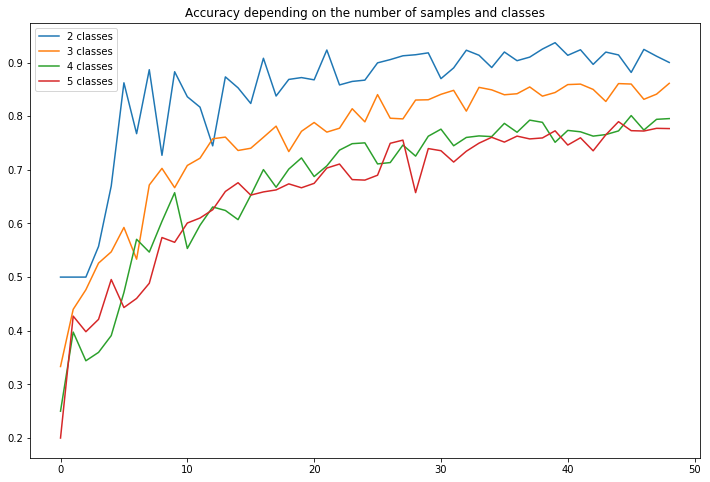

In [440]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_xg_aug[2], label="2 classes")
plt.plot(all_accuracy_xg_aug[3], label="3 classes")
plt.plot(all_accuracy_xg_aug[4], label="4 classes")
plt.plot(all_accuracy_xg_aug[5], label="5 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()

### III.5.e. Summary

In [428]:
df_results = pd.DataFrame({
    'Nb Classes':[2,3,4,5], 
    'min K-NN':[min(all_accuracy_knn[2]), 
                min(all_accuracy_knn[3]), 
                min(all_accuracy_knn[4]), 
                min(all_accuracy_knn[5])],
    'min Cosine':[min(all_accuracy[2]), 
            min(all_accuracy[3]), 
            min(all_accuracy[4]), 
            min(all_accuracy[5])],
    'min K-NN Aug.':[min(all_accuracy_knn_aug[2]), 
                min(all_accuracy_knn_aug[3]), 
                min(all_accuracy_knn_aug[4]), 
                min(all_accuracy_knn_aug[5])],
    'min Cosine Aug.':[min(all_accuracy_aug[2]), 
            min(all_accuracy_aug[3]), 
            min(all_accuracy_aug[4]), 
            min(all_accuracy_aug[5])],
    'mean K-NN':[np.mean(all_accuracy_knn[2]), 
                np.mean(all_accuracy_knn[3]), 
                np.mean(all_accuracy_knn[4]), 
                np.mean(all_accuracy_knn[5])],
    'mean Cosine':[np.mean(all_accuracy[2]), 
            np.mean(all_accuracy[3]), 
            np.mean(all_accuracy[4]), 
            np.mean(all_accuracy[5])],
    'mean K-NN Aug.':[np.mean(all_accuracy_knn_aug[2]), 
                np.mean(all_accuracy_knn_aug[3]), 
                np.mean(all_accuracy_knn_aug[4]), 
                np.mean(all_accuracy_knn_aug[5])],
    'mean Cosine Aug.':[np.mean(all_accuracy_aug[2]), 
            np.mean(all_accuracy_aug[3]), 
            np.mean(all_accuracy_aug[4]), 
            np.mean(all_accuracy_aug[5])],
    'max K-NN':[max(all_accuracy_knn[2]), 
                max(all_accuracy_knn[3]), 
                max(all_accuracy_knn[4]), 
                max(all_accuracy_knn[5])],
    'max Cosine':[max(all_accuracy[2]), 
            max(all_accuracy[3]), 
            max(all_accuracy[4]), 
            max(all_accuracy[5])],
    'max K-NN Aug.':[max(all_accuracy_knn_aug[2]), 
                max(all_accuracy_knn_aug[3]), 
                max(all_accuracy_knn_aug[4]), 
                max(all_accuracy_knn_aug[5])],
    'max Cosine Aug.':[max(all_accuracy_aug[2]), 
            max(all_accuracy_aug[3]), 
            max(all_accuracy_aug[4]), 
            max(all_accuracy_aug[5])]
})

df_results

,Nb Classes,min K-NN,min Cosine,min K-NN Aug.,min Cosine Aug.,mean K-NN,mean Cosine,mean K-NN Aug.,mean Cosine Aug.,max K-NN,max Cosine,max K-NN Aug.,max Cosine Aug.
0,2,0.533567,0.619119,0.602204,0.825651,0.871367,0.944429,0.868350,0.947528,0.952604,0.972567,0.952083,0.977064
1,3,0.383050,0.512179,0.356495,0.470608,0.763637,0.629524,0.749904,0.625898,0.885764,0.648555,0.900000,0.650256
2,4,0.265281,0.412162,0.352705,0.262763,0.665189,0.473001,0.669820,0.469623,0.838854,0.487408,0.814651,0.488083
3,5,0.327928,0.347390,0.406212,0.296994,0.658054,0.378756,0.652177,0.377612,0.815000,0.389121,0.836765,0.389342


In [40]:
df_results_rf = pd.DataFrame({
    'Nb Classes':[2,3,4,5], 
    'mean K-NN Aug.':[np.mean(all_accuracy_knn_aug[2]), 
                np.mean(all_accuracy_knn_aug[3]), 
                np.mean(all_accuracy_knn_aug[4]), 
                np.mean(all_accuracy_knn_aug[5])],
    'mean RF Aug.':[np.mean(all_accuracy_rf_aug[2]), 
                np.mean(all_accuracy_rf_aug[3]), 
                np.mean(all_accuracy_rf_aug[4]), 
                np.mean(all_accuracy_rf_aug[5])],
})
df_results_rf

,Nb Classes,mean K-NN Aug.,mean RF Aug.
0,2,0.871367,0.922545
1,3,0.763637,0.848979
2,4,0.665189,0.776615
3,5,0.658054,0.773353


# IV. More embeddings

The embeddings we chose is quite simple (Word2Vec) and recent state of the art embeddings (GPT-2, XLNet, BERT) have outperformed this embedding and were trained on a larger corpus.

In [69]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_transformers import *
from pytorch_pretrained_bert import BertAdam

model_class = DistilBertModel
tokenizer_class = DistilBertTokenizer
pretrained_weights = 'distilbert-base-uncased'

tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


In [142]:
sentences = train.Text.values
token_ids = ([(tokenizer.encode(sent)) for sent in sentences])

In [165]:
X_train = []
for tokens in token_ids:
    outputs = model(torch.tensor(tokens).unsqueeze(0))[0]
    X_train.append(np.mean(outputs[0].detach().numpy(), axis=0))

In [164]:
sentences_test = test.Text.values
token_ids_test = ([(tokenizer.encode(sent)) for sent in sentences_test])

X_test = []
for tokens in token_ids_test:
    outputs = model(torch.tensor(tokens).unsqueeze(0))[0]
    X_test.append(np.mean(outputs[0].detach().numpy(), axis=0))

In [166]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [167]:
clf = RandomForestClassifier(n_estimators=150)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [168]:
y_pred = clf.predict(X_test)
accuracy_score(y_pred, y_test)

In [169]:
accuracy_score(y_pred, y_test)

0.8765060240963856

In [171]:
def return_score_bert(sample_size, num_classes):
    
    train, test = gen_sample(sample_size, num_classes)
    
    X_train = train['Text']
    y_train = train['Label'].values
    X_test = test['Text']
    y_test = test['Label'].values

    train_sentences = train.Text.values
    train_token_ids = ([(tokenizer.encode(sent)) for sent in train_sentences])
    
    test_sentences = test.Text.values
    test_token_ids = ([(tokenizer.encode(sent)) for sent in test_sentences])

    X_train = []
    for tokens in train_token_ids:
        outputs = model(torch.tensor(tokens).unsqueeze(0))[0]
        X_train.append(np.mean(outputs[0].detach().numpy(), axis=0))

    X_test = []
    for tokens in test_token_ids:
        outputs = model(torch.tensor(tokens).unsqueeze(0))[0]
        X_test.append(np.mean(outputs[0].detach().numpy(), axis=0))
        
    X_train = np.array(X_train)
    X_test = np.array(X_test)
    
    clf = RandomForestClassifier(n_estimators=150)
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    return accuracy_score(y_pred, y_test)

In [173]:
all_accuracy_bert = {2:[],3:[],4:[],5:[]}

for num_samples in range(1,50):
    print(num_samples)
    for num_cl in range(2, 6):
        all_accuracy_bert[num_cl].append(return_score_bert(num_samples,num_cl))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


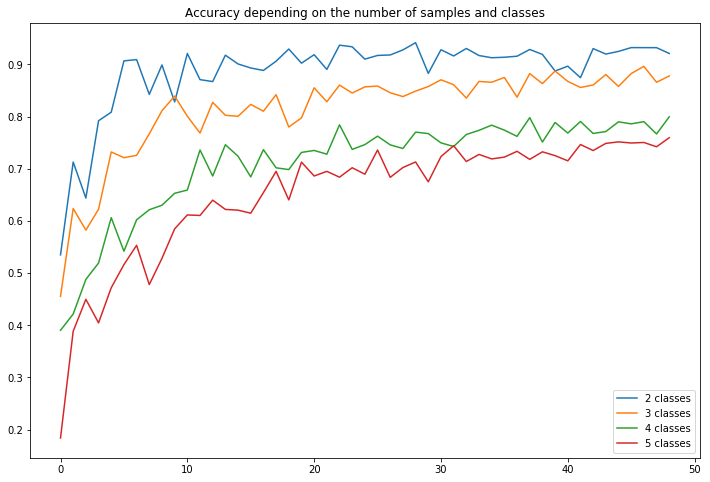

In [174]:
plt.figure(figsize=(12,8))
plt.plot(all_accuracy_bert[2], label="2 classes")
plt.plot(all_accuracy_bert[3], label="3 classes")
plt.plot(all_accuracy_bert[4], label="4 classes")
plt.plot(all_accuracy_bert[5], label="5 classes")
plt.title("Accuracy depending on the number of samples and classes")
plt.legend()
plt.show()